# Model Training


In [140]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_path


'f:\\Work\\Energy Prediction\\data'

In [141]:
# Read data
df = pd.read_csv(data_path + '/final_data/data.csv')
# drop NaN values
df = df.dropna()

In [142]:
df.columns

Index(['country', 'year', 'Final Consumption', 'Demand', 'Production', 'gdp',
       'population', 'gInf', 'Final Consumption % of gdp', 'Demand % of gdp',
       'Production % of Demand', 'Final Consumption per capita',
       'Demand per capita', 'Normalized Final Consumption',
       'Normalized Demand', 'Normalized Production',
       'Production-Demand Imbalance', 'Energy Loss Ratio', 'GDP per capita',
       'gInf Growth Rate', 'gdp Growth Rate', 'population Growth Rate'],
      dtype='object')

In [190]:
categorical_features = ['country']
numerical_features = ['year', 'gdp',
                      'population', 'gInf',
                      'Demand per capita',
                      'GDP per capita',
                      'gInf Growth Rate', 'gdp Growth Rate', 'population Growth Rate']
features = categorical_features + numerical_features
target_feature = ['Final Consumption']


In [209]:
# apply random forest feature selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# convert categorical to numerical
le = LabelEncoder()
df['country'] = le.fit_transform(df['country'])

# split data
X_train, X_test, y_train, y_test = train_test_split(
    df[numerical_features + categorical_features], df['Final Consumption'], test_size=0.2, random_state=0)

In [210]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# select features
sel = SelectFromModel(RandomForestRegressor(n_estimators=100))
sel.fit(X_train, y_train)

# selected features
selected_feat = X_train.columns[(sel.get_support())]
len(selected_feat)

# features
print("Selected features by random forest:", selected_features.tolist())

Selected features by random forest: ['gdp', 'population', 'gInf', 'Demand per capita', 'GDP per capita']


In [211]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split

# Select features using Mutual Information
k = 5  # Number of top features to select
sel = SelectKBest(score_func=mutual_info_regression, k=k)
X_train_selected = sel.fit_transform(X_train, y_train)
X_test_selected = sel.transform(X_test)

# Get the indices of the selected features
selected_indices = sel.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_indices]

print("Selected features by Mutual Information:", selected_features.tolist())


Selected features by Mutual Information: ['gdp', 'population', 'Demand per capita', 'GDP per capita', 'country']


In [199]:
# group by country and year
countries_data = df.groupby(['year']).sum().reset_index()


In [200]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Split the data based on the year (train on earlier years, test on later years)
train_data = countries_data[countries_data['year'] < 2010]
test_data = countries_data[countries_data['year'] >= 2010]

# Split the data into training and testing sets
X_train = train_data[numerical_features]
y_train = train_data[target_feature]
X_test = test_data[numerical_features]
y_test = test_data[target_feature]

# Create and fit the multivariate linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (you can use appropriate evaluation metrics for your task)

# Calculate mean squared error and R2 score for each target variable
for i, target_var in enumerate(target_feature):
    mse = mean_squared_error(y_test[target_var], y_pred[:, i])
    r2 = r2_score(y_test[target_var], y_pred[:, i])
    print(f"Target Variable: {target_var}")
    print("Mean squared error:", mse)
    print("R2 score:", r2)

# Print the coefficients and intercept for each target variable
# for i, target_var in enumerate(target_variables):
#     print(f"Coefficients for {target_var}:", model.coef_[i])
# print("Intercept:", model.intercept_)


Target Variable: Final Consumption
Mean squared error: 0.0001203372610734705
R2 score: 0.7311058239226063


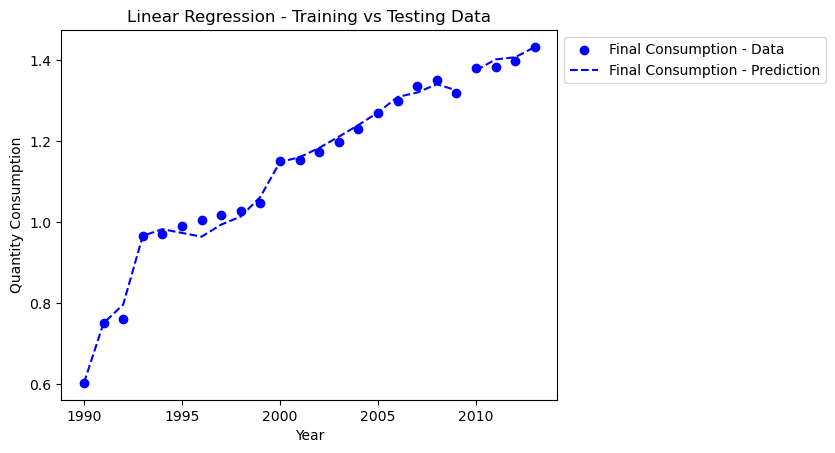

In [201]:
import matplotlib.pyplot as plt

# Define colors for different features
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot the linear line for each target variable for training data
for i, target_var in enumerate(target_feature):
    plt.scatter(X_train['year'], y_train[target_var], color=colors[i % len(
        colors)], marker='o', label=f'{target_var} - Data')
    plt.plot(X_train['year'], model.predict(X_train)[:, i], color=colors[i % len(
        colors)], linestyle='--', label=f'{target_var} - Prediction')

# Plot the linear line for each target variable for testing data
for i, target_var in enumerate(target_feature):
    plt.scatter(X_test['year'], y_test[target_var],
                color=colors[i % len(colors)], marker='o')
    plt.plot(X_test['year'], y_pred[:, i],
             color=colors[i % len(colors)], linestyle='--')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Quantity Consumption')
plt.title('Linear Regression - Training vs Testing Data')

# Add legend (use bbox_to_anchor to move the legend outside the plot)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


## Deep Learning model


In [202]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Assuming you have already defined numerical_features and target_feature

# group by year
countries_data = df.groupby(['year', 'country']).sum().reset_index()

# Select features and target variable
features = numerical_features + categorical_features
target = target_feature

# # label encode category
le = LabelEncoder()
countries_data[categorical_features] = countries_data[categorical_features].apply(
    lambda col: le.fit_transform(col))

# Split the data by 0.8/0.2, train, test split
train_data, test_data = train_test_split(
    countries_data, test_size=0.2, random_state=0)

# Split the data into training and testing sets
X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# Apply scalling to the data range 0 to 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [203]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out


# print(X_train.shape)
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Convert tensors back to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()


# Evaluate the model (you can use appropriate evaluation metrics for your task)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

# Print the coefficients and intercept
# print("Parameters (weights):", model.state_dict())

Epoch [10/100], Loss: 0.0069
Epoch [20/100], Loss: 0.0029
Epoch [30/100], Loss: 0.0020
Epoch [40/100], Loss: 0.0016
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0004
Mean squared error: 0.0013738843
R2 score: 0.5983095815887853


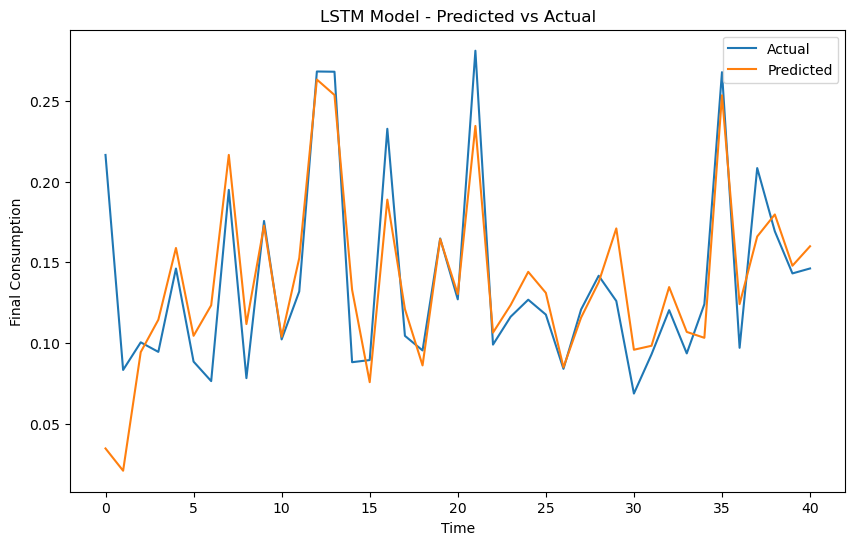

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Final Consumption')
plt.title('LSTM Model - Predicted vs Actual')
plt.legend()
plt.show()

In [205]:

# Split the data into training and testing sets
X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# Apply scalling to the data range 0 to 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape the input data to have one channel
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Define the CNN model


class CNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size,
                               out_channels=32, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2)
        # Calculate the appropriate size based on input data
        self.fc1 = nn.Linear(64 * (X_train.shape[2] - 2), 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the data for the fully connected layer
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]
output_size = 1

model = CNNModel(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Convert tensors back to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()

# Inverse transform the scaled predictions back to the original scale
y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Evaluate the model (you can use appropriate evaluation metrics for your task)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

Shape of X_train: torch.Size([161, 1, 10])
Shape of X_test: torch.Size([41, 1, 10])
Epoch [10/100], Loss: 0.0038
Epoch [20/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0007
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001
Mean squared error: 0.004472774
R2 score: -0.30773034416809675


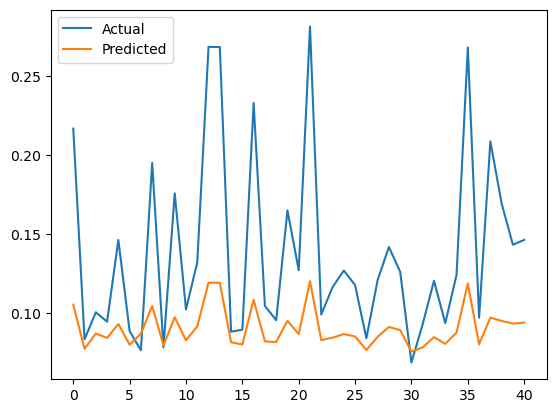

In [206]:
# Plot the actual and predicted values
import matplotlib.pyplot as plt
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [207]:

# Split the data into training and testing sets
X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# Apply scalling to the data range 0 to 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape the input data to have one channel
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Reshape the input data to have multiple time steps (sequence length) and batch size
# For RNN, the input shape should be (sequence_length, batch_size, input_size)
# Use the entire time series as one sequence
sequence_length = X_train.shape[0]
batch_size = 1  # Set batch size to 1 (since we have only one sequence)
input_size = X_train.shape[2]

# Swap dimensions to (sequence_length, batch_size, input_size)
X_train_rnn = X_train.permute(1, 0, 2)
X_test_rnn = X_test.permute(1, 0, 2)

# Define the RNN model


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


hidden_size = 128
output_size = 1

model = RNNModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Convert tensors back to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()

# Inverse transform the scaled predictions back to the original scale
y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Evaluate the model (you can use appropriate evaluation metrics for your task)
print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))


Epoch [10/100], Loss: 0.0020
Epoch [20/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0006
Epoch [40/100], Loss: 0.0007
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004
Mean squared error: 0.0045150663
R2 score: -0.3200956917541664


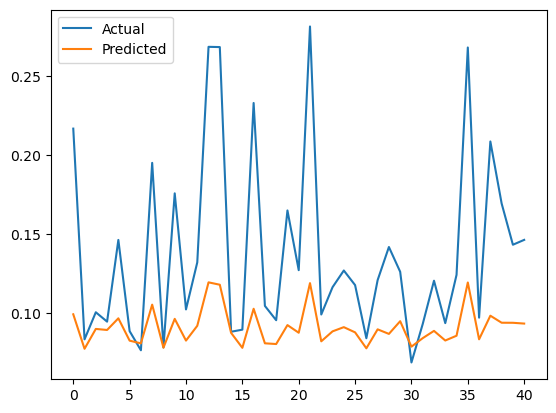

In [208]:
# Plot the actual and predicted values
import matplotlib.pyplot as plt
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

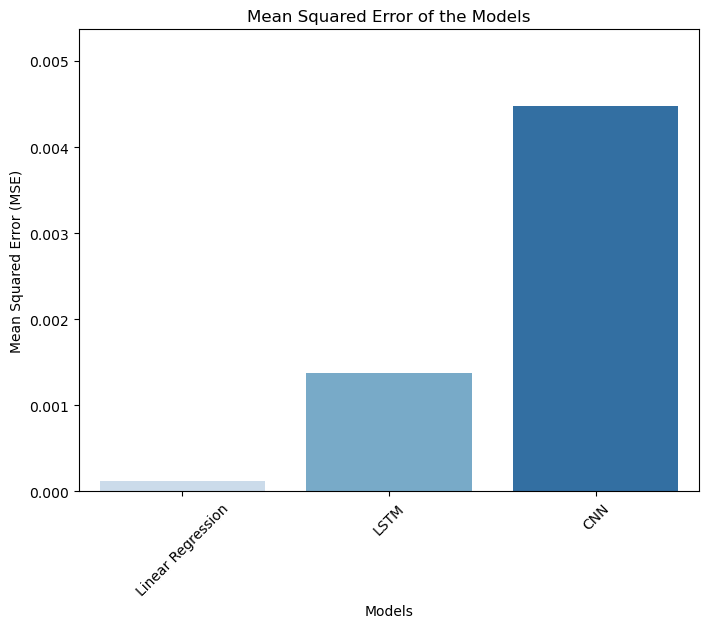

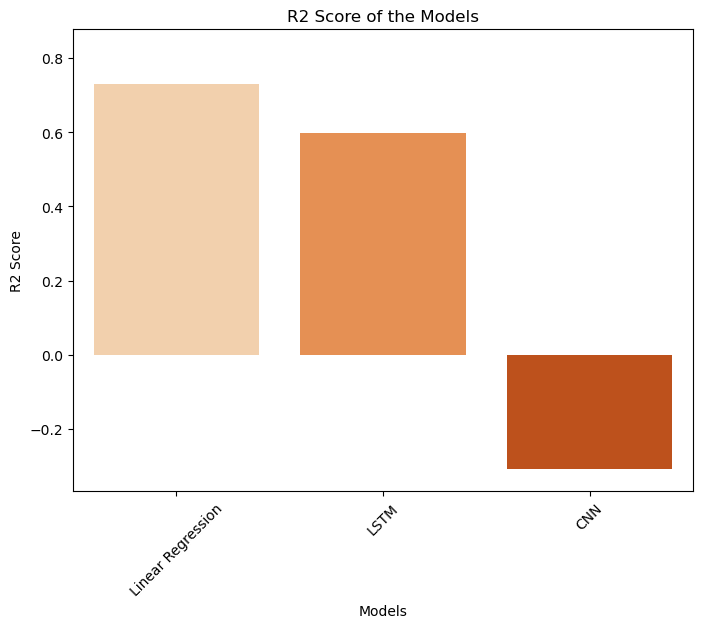

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Results data
models = ['Linear Regression', 'LSTM', 'CNN']
mse_scores = [0.0001203372610734705, 0.0013738843, 0.004472774]
r2_scores = [0.7311058239226063, 0.5983095815887853, -0.30773034416809675]

# Plotting the Mean Squared Error
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=mse_scores, palette='Blues')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error of the Models')
plt.ylim(0, max(mse_scores) * 1.2)
plt.xticks(rotation=45)
plt.show()

# Plotting the R2 scores
plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=r2_scores, palette='Oranges')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.title('R2 Score of the Models')
plt.ylim(min(r2_scores) * 1.2, max(r2_scores) * 1.2)
plt.xticks(rotation=45)
plt.show()